In [1]:
import numpy as np
import pandas as pd

# Constructing initial dataframes

In [2]:
df_projects = pd.read_csv('data/projectList.csv')

#Drop Title, ArticleURL columns. They are from the original article and are not needed
# Drop unnecessary columns
columns_to_drop = [ 'Family', 'Language', 'glottocode', 'isocode', 'Speakers']
df_projects.drop(columns_to_drop, axis=1, inplace=True)
# Delete duplicates from the dataset. As we have dropped the language related columns, we will consider the project name and the country as discerning factors
df_projects.drop_duplicates(inplace=True)
print("We begin the analysis with {} projects".format(df_projects.shape[0]))

origins = np.array(['State initiative', 'External organization',
                          'Universities and institutes',
                          'Alternative projects from the community'])
df_num_projects_year=df_projects.groupby('Year')[origins].sum()

df_num_projects_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_num_projects_year.index:
    for column in df_num_projects_year.columns:
        df_num_projects_expanded.loc[len(df_num_projects_expanded)] = [year, column, df_num_projects_year.loc[year, column]]

We begin the analysis with 439 projects


Another dataframe for storing proportions of each origin by year

In [3]:
total_proyectos = df_projects.groupby('Year').size()
df_prop_projects_year = df_num_projects_year.div(total_proyectos, axis=0)

df_prop_projects_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_prop_projects_year.index:
    for column in df_prop_projects_year.columns:
        df_prop_projects_expanded.loc[len(df_prop_projects_expanded)] = [year, column, df_prop_projects_year.loc[year, column]]

# Statistical tests

In [4]:
valid_years= range(2000, 2022)

df_num_projects_expanded = df_num_projects_expanded[df_num_projects_expanded['Year'].isin(valid_years)]
df_num_projects_year = df_num_projects_year[df_num_projects_year.index.isin(valid_years)]
df_prop_projects_year = df_prop_projects_year[df_prop_projects_year.index.isin(valid_years)]
df_prop_projects_expanded =  df_prop_projects_expanded[df_prop_projects_expanded['Year'].isin(valid_years)]


# Comparing  each origin's proportion by year

Shapiro-Wilk test for State initiative: stat=0.7818669731679476, p=0.0021716685514722852
Shapiro-Wilk test for External organization: stat=0.7184190503622683, p=0.00039390956643378146
Shapiro-Wilk test for Universities and institutes: stat=0.8052638546913455, p=0.004298350740398105
Shapiro-Wilk test for Alternative projects from the community: stat=0.9264042150457344, p=0.24096332690893024


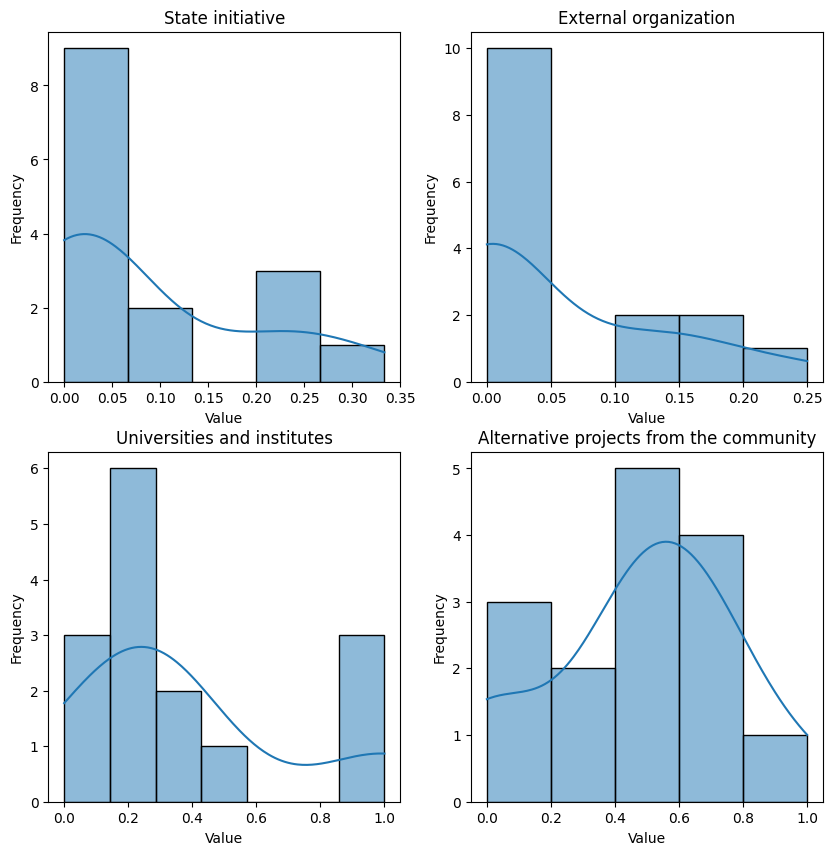

In [5]:
#Before doing an ANOVA, we need to check if each one of the groups has a normal distribution using the Shapiro-Wilk test and plot the distribution of each group
#in a 2x2 grid
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, column in enumerate(df_prop_projects_year.columns):
    data = df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == column]['Value']
    sns.histplot(data, kde=True, ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    stat, p = shapiro(data)
    print('Shapiro-Wilk test for {}: stat={}, p={}'.format(column, stat, p))

As most of the groups are not normally distributed, we will use the Kruskal-Wallis test to compare the proportions of each origin by year.

In [6]:
#Test for homogeneity of variances using Levene's test
from scipy.stats import levene

stat, p = levene(df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'State initiative']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'External organization']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Universities and institutes']['Value'])
print('Levene test: stat={}, p={}'.format(stat, p))

Levene test: stat=3.864296343987006, p=0.013914908362763028


The evidence indicates that the variances are not equal, so we will need to consider that when interpreting the results.

In [7]:
from scipy.stats import kruskal

H = kruskal(df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'State initiative']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'External organization']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Universities and institutes']['Value'])
print('Kruskal-Wallis test: H={}, p={}'.format(H.statistic, H.pvalue))

Kruskal-Wallis test: H=23.08028675904543, p=3.885643894116411e-05


The p-value is significant, so we can reject the null hypothesis that the proportions of each origin are the same for each year. That means that at least one group is stochastically different from the others.

In [11]:
from scikit_posthocs import posthoc_dunn

df_prop_projects_expanded['Origin'] = df_prop_projects_expanded['Origin'].astype('category')
posthoc = posthoc_dunn(df_prop_projects_expanded, val_col='Value', group_col='Origin', p_adjust='holm')
print(posthoc)


                                         Alternative projects from the community  \
Alternative projects from the community                                 1.000000   
External organization                                                   0.000414   
State initiative                                                        0.004022   
Universities and institutes                                             1.000000   

                                         External organization  \
Alternative projects from the community               0.000414   
External organization                                 1.000000   
State initiative                                      1.000000   
Universities and institutes                           0.004022   

                                         State initiative  \
Alternative projects from the community          0.004022   
External organization                            1.000000   
State initiative                                 1.000000   
Univ

c:\Users\Maracuya\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikit_posthocs\_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Maracuya\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikit_posthocs\_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


That is, the proportion of projects whose origin is "Alternative projects from the community" tends to be higher than those with a "State initiative" or "External organization" origin. 

# Now we compare absolute values

Shapiro-Wilk test for State initiative: stat=0.7702652765268114, p=0.0015655048144196297
Shapiro-Wilk test for External organization: stat=0.6225599081209687, p=4.13377379023106e-05
Shapiro-Wilk test for Universities and institutes: stat=0.7711930022441912, p=0.00160659214841758
Shapiro-Wilk test for Alternative projects from the community: stat=0.7980823305655883, p=0.003474138842308


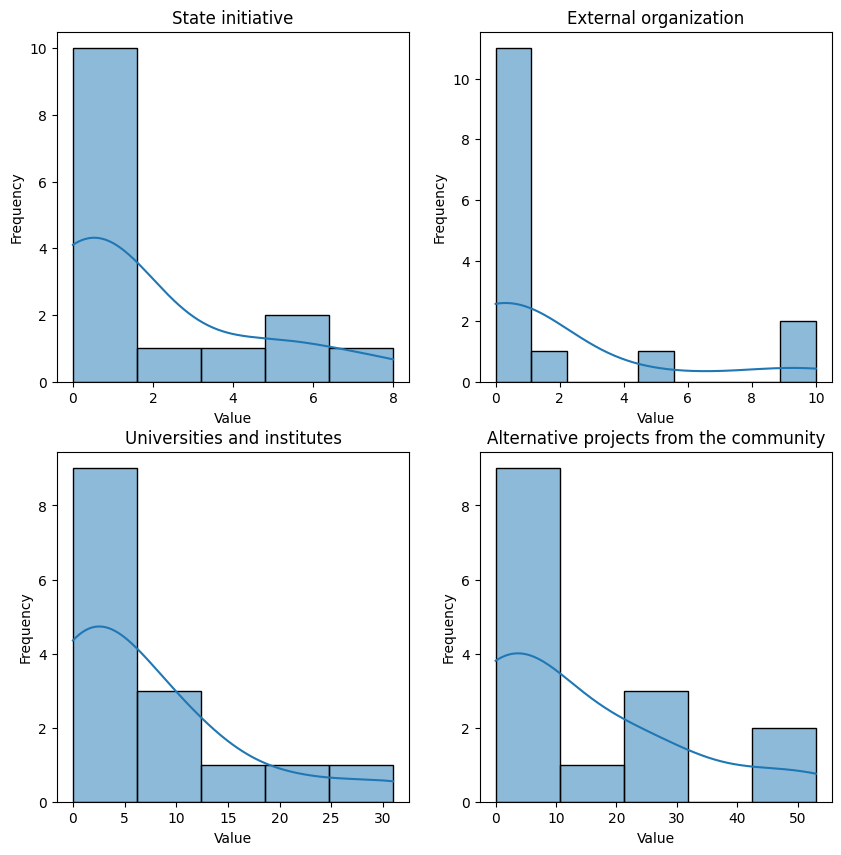

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, column in enumerate(df_num_projects_year.columns):
    data = df_num_projects_expanded[df_num_projects_expanded['Origin'] == column]['Value']
    sns.histplot(data, kde=True, ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    stat, p = shapiro(data)
    print('Shapiro-Wilk test for {}: stat={}, p={}'.format(column, stat, p))

Data is not normally distributed but their distributions are similar. Let's check for homoscedasticity.

In [16]:
#Check homoscedasticity using Levene's test
from scipy.stats import levene

levene_test = levene(df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'State initiative']['Value'],
                        df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'External organization']['Value'],
                        df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'Universities and institutes']['Value'],
                        df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'])
print('Levene test: stat={}, p={}'.format(levene_test.statistic, levene_test.pvalue))

Levene test: stat=4.780650940579276, p=0.0049035724235723215


As the p-value is significant, we can reject the null hypothesis that the variances are equal. That means that we need to consider that when interpreting the results.

In [17]:
#There is evidence to discard homoscedasticity, so we can use kruskal-wallis test

H = kruskal(df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'State initiative']['Value'],
            df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'External organization']['Value'],
            df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'Universities and institutes']['Value'],
            df_num_projects_expanded[df_num_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'])
print('Kruskal-Wallis test: H={}, p={}'.format(H.statistic, H.pvalue))


Kruskal-Wallis test: H=11.638130667286678, p=0.008731389846703378


The Kruskal-Wallis test indicates that the p-value is significant, so we can reject the null hypothesis and conclude that at least one group is different from the others. As the shapes of the distributions are similar, we can say that the medians are different. Let's run a post-hoc test to check which groups are different from the others.

In [19]:
#Post-hoc test for Kruskal-Wallis using dunn-bonferroni
from scikit_posthocs import posthoc_dunn

df_num_projects_expanded['Origin'] = df_num_projects_expanded['Origin'].astype('category')
posthoc = posthoc_dunn(df_num_projects_expanded, val_col='Value', group_col='Origin', p_adjust='holm')
print(posthoc)

                                         Alternative projects from the community  \
Alternative projects from the community                                 1.000000   
External organization                                                   0.023352   
State initiative                                                        0.088083   
Universities and institutes                                             1.000000   

                                         External organization  \
Alternative projects from the community               0.023352   
External organization                                 1.000000   
State initiative                                      1.000000   
Universities and institutes                           0.088083   

                                         State initiative  \
Alternative projects from the community          0.088083   
External organization                            1.000000   
State initiative                                 1.000000   
Univ

c:\Users\Maracuya\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikit_posthocs\_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Maracuya\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikit_posthocs\_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()


With this test we can also conclude that the median of the "Alternative projects from the community" group is higher than the medians of "State initiative" and "External organization" groups.

# Testing growth

In [20]:
#Make a Mann-Kendall test for trend
import pymannkendall as mk

for column in df_prop_projects_year.columns:
    result = mk.yue_wang_modification_test(df_prop_projects_year[column].values)
    print('Mann-Kendall test for {}: {}'.format(column, result))

print('\n')

for column in df_num_projects_year.columns:
    result = mk.yue_wang_modification_test(df_num_projects_year[column].values)
    print('Mann-Kendall test for {}: {}'.format(column, result))

Mann-Kendall test for State initiative: Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='no trend', h=False, p=0.06859923355654662, z=1.8210501524899645, Tau=0.19047619047619047, s=20.0, var_s=108.85876142333998, slope=0.002325581395348837, intercept=0.01497093023255814)
Mann-Kendall test for External organization: Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.017526632104368556, z=2.3754696834783346, Tau=0.1619047619047619, s=17.0, var_s=45.367096050242054, slope=0.0, intercept=0.0)
Mann-Kendall test for Universities and institutes: Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='no trend', h=False, p=0.4337275763348698, z=-0.7828289302792841, Tau=-0.10476190476190476, s=-11.0, var_s=163.1797508905515, slope=-0.011695906432748537, intercept=0.34502923976608185)
Mann-Kendall test for Alternative projects from the community: Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=0.01549847797805226, z=2.4205164516077935, Tau=0.25

The Mann-Kendall test is used to check if there is a trend in the data. We can see that when talking about the absolute count of projects, all origins have a positive trend, with the "Alternative projects from the community" group having the highest growth rate (biggest slope).

When we look at the proportions, we can see that the "Alternative projects from the community" group has also a positive trend. Both State initiative and Universities and Institutes have no significant trend. External organizations have also a positive trend.